##### Purpose of the notebook ####

Explore gene modules present within different cell types, defining subtypes. In this case: oligodendrocytes.

In [80]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
#from xb.formatting import *

# format to adata using modules from xenium benchmarking 

In [2]:
files=['/media/sergio/GBX/xenium_prerelease_nov23_5k_v2/xenium_prerelease_nov23_5k/hLiver_FF']
saving_path='/media/sergio/Ymir/5kovarian_for_cnv/figures'

In [3]:
adata=sc.read('/media/sergio/Ymir/5kovarian_for_cnv/adata_unprocessed.h5ad')

/home/sergio/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


# Start CNV inference with InferCNV

In [16]:
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
import warnings

In [6]:
dat = cnv.datasets.maynard2020_3k()
dat.var.loc[:, ["ensg", "chromosome", "start", "end"]].head()

ensg chromosome      start        end
symbol                                                        
AL645933.5  ENSG00000288587.1       chr6   31400702   31463705
AC010184.1  ENSG00000288585.1       chr3  141449745  141456434
AC023296.1  ENSG00000288580.1       chr8    2923568    2926689
AL117334.2  ENSG00000288577.1      chr20    3406380    3410036
AC107294.4  ENSG00000288576.1       chr3  184778723  184780720

In [8]:
adata=adata[:,adata.var.index.isin(dat.var['gene_name'])]
name2gid=dict(zip(dat.var['gene_name'],dat.var['gene_id']))
name2symbol=dict(zip(dat.var['gene_name'],dat.var.index))
adata.var['gene_id']=adata.var.index.map(name2gid)
adata.var['symbol']=adata.var.index.map(name2symbol)
name2ensg=dict(zip(dat.var['gene_name'],dat.var['ensg']))
name2chromosome=dict(zip(dat.var['gene_name'],dat.var['chromosome']))
name2start=dict(zip(dat.var['gene_name'],dat.var['start']))
name2end=dict(zip(dat.var['gene_name'],dat.var['end']))
adata.var['ensg']=adata.var.index.map(name2ensg)
adata.var['chromosome']=adata.var.index.map(name2chromosome)
adata.var['start']=adata.var.index.map(name2start)
adata.var['end']=adata.var.index.map(name2end)

In [13]:
adata.write('/media/sergio/Ymir/5kovarian_for_cnv/adata_unprocessed_all.h5ad')

... storing 'chromosome' as categorical


# read unprocessed adata

In [6]:
adata=sc.read('/media/sergio/Ymir/5kovarian_for_cnv/adata_unprocessed_all.h5ad')

In [7]:
adata.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 952827651 stored elements and shape (1157659, 4993)>

In [3]:
#sc.pp.subsample(adata,0.25)

In [8]:
adata.layers['raw']=adata.X.copy()

In [12]:
sc.pp.filter_cells(adata,min_genes=5)
sc.pp.filter_cells(adata,min_counts=10)

In [14]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_pcs=50)

In [16]:
sc.tl.leiden(adata)
sc.tl.umap(adata)

/tmp/ipykernel_1358100/3467744858.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


In [19]:
adata.write('/media/sergio/Ymir/5kovarian_for_cnv/adata_umap.h5ad')

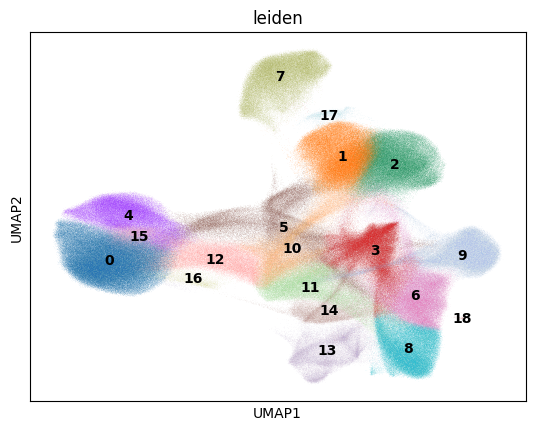

In [20]:
sc.pl.umap(adata,color='leiden',legend_loc='on data')

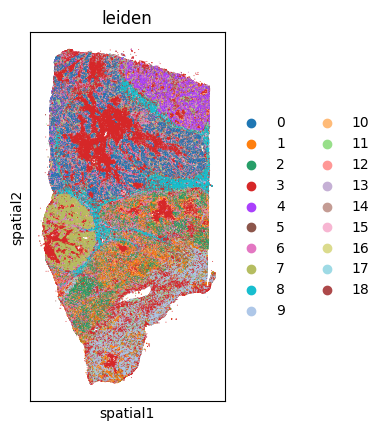

In [21]:
sc.pl.spatial(adata,color='leiden',spot_size=60)

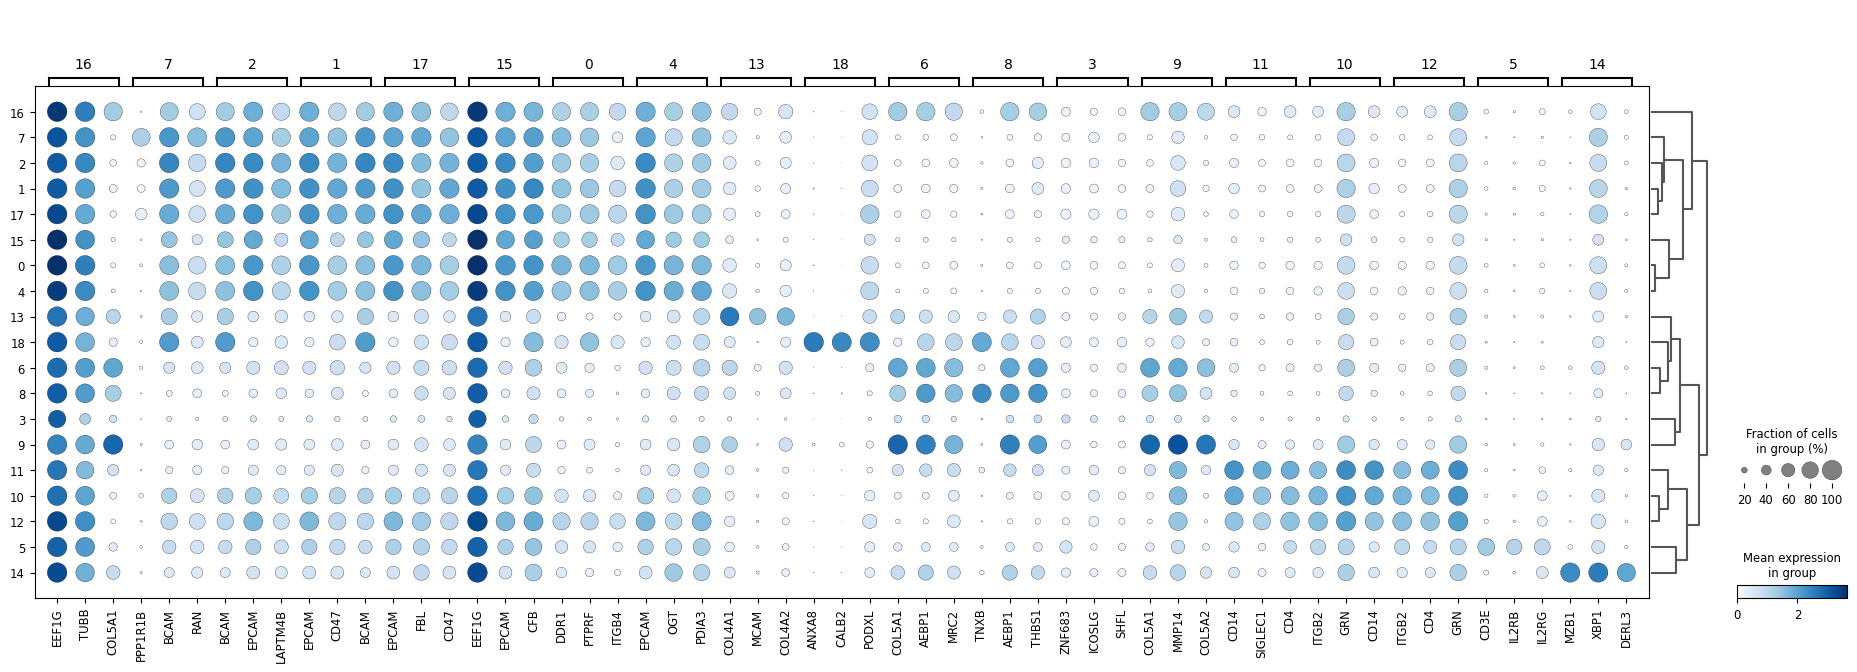

In [26]:
import numpy as np
sc.tl.rank_genes_groups(adata,groupby='leiden')
sc.pl.rank_genes_groups_dotplot(adata,n_genes=3,cmap='Blues')

# Anotate cell populations

In [89]:
annotation_dict={'0':'Epithelial','1':'Epithelial','2':'Epithelial','3':'Low expression','4':'Epithelial','5':'T cells','6':'Fibroblasts',
'7':'Epithelial','8':'Fibroblasts','9':'Fibroblasts','10':'Monocytes','11':'Monocytes','12':'Monocytes','13':'Endothelial',
'14':'B cells','15':'Epithelial','16':'Epithelial','17':'Epithelial','18':'Fibroblasts'}

In [90]:
adata.obs['cell class']=adata.obs['leiden'].map(annotation_dict).astype('str').astype('category')

In [91]:
colormap=['#2176AE','#57B8FF','#FF37A6','#87E752','#FFCAE9','#ffaf94','#FBB13C','#B66D0D']

In [92]:
adata.uns['cell class_colors']=colormap

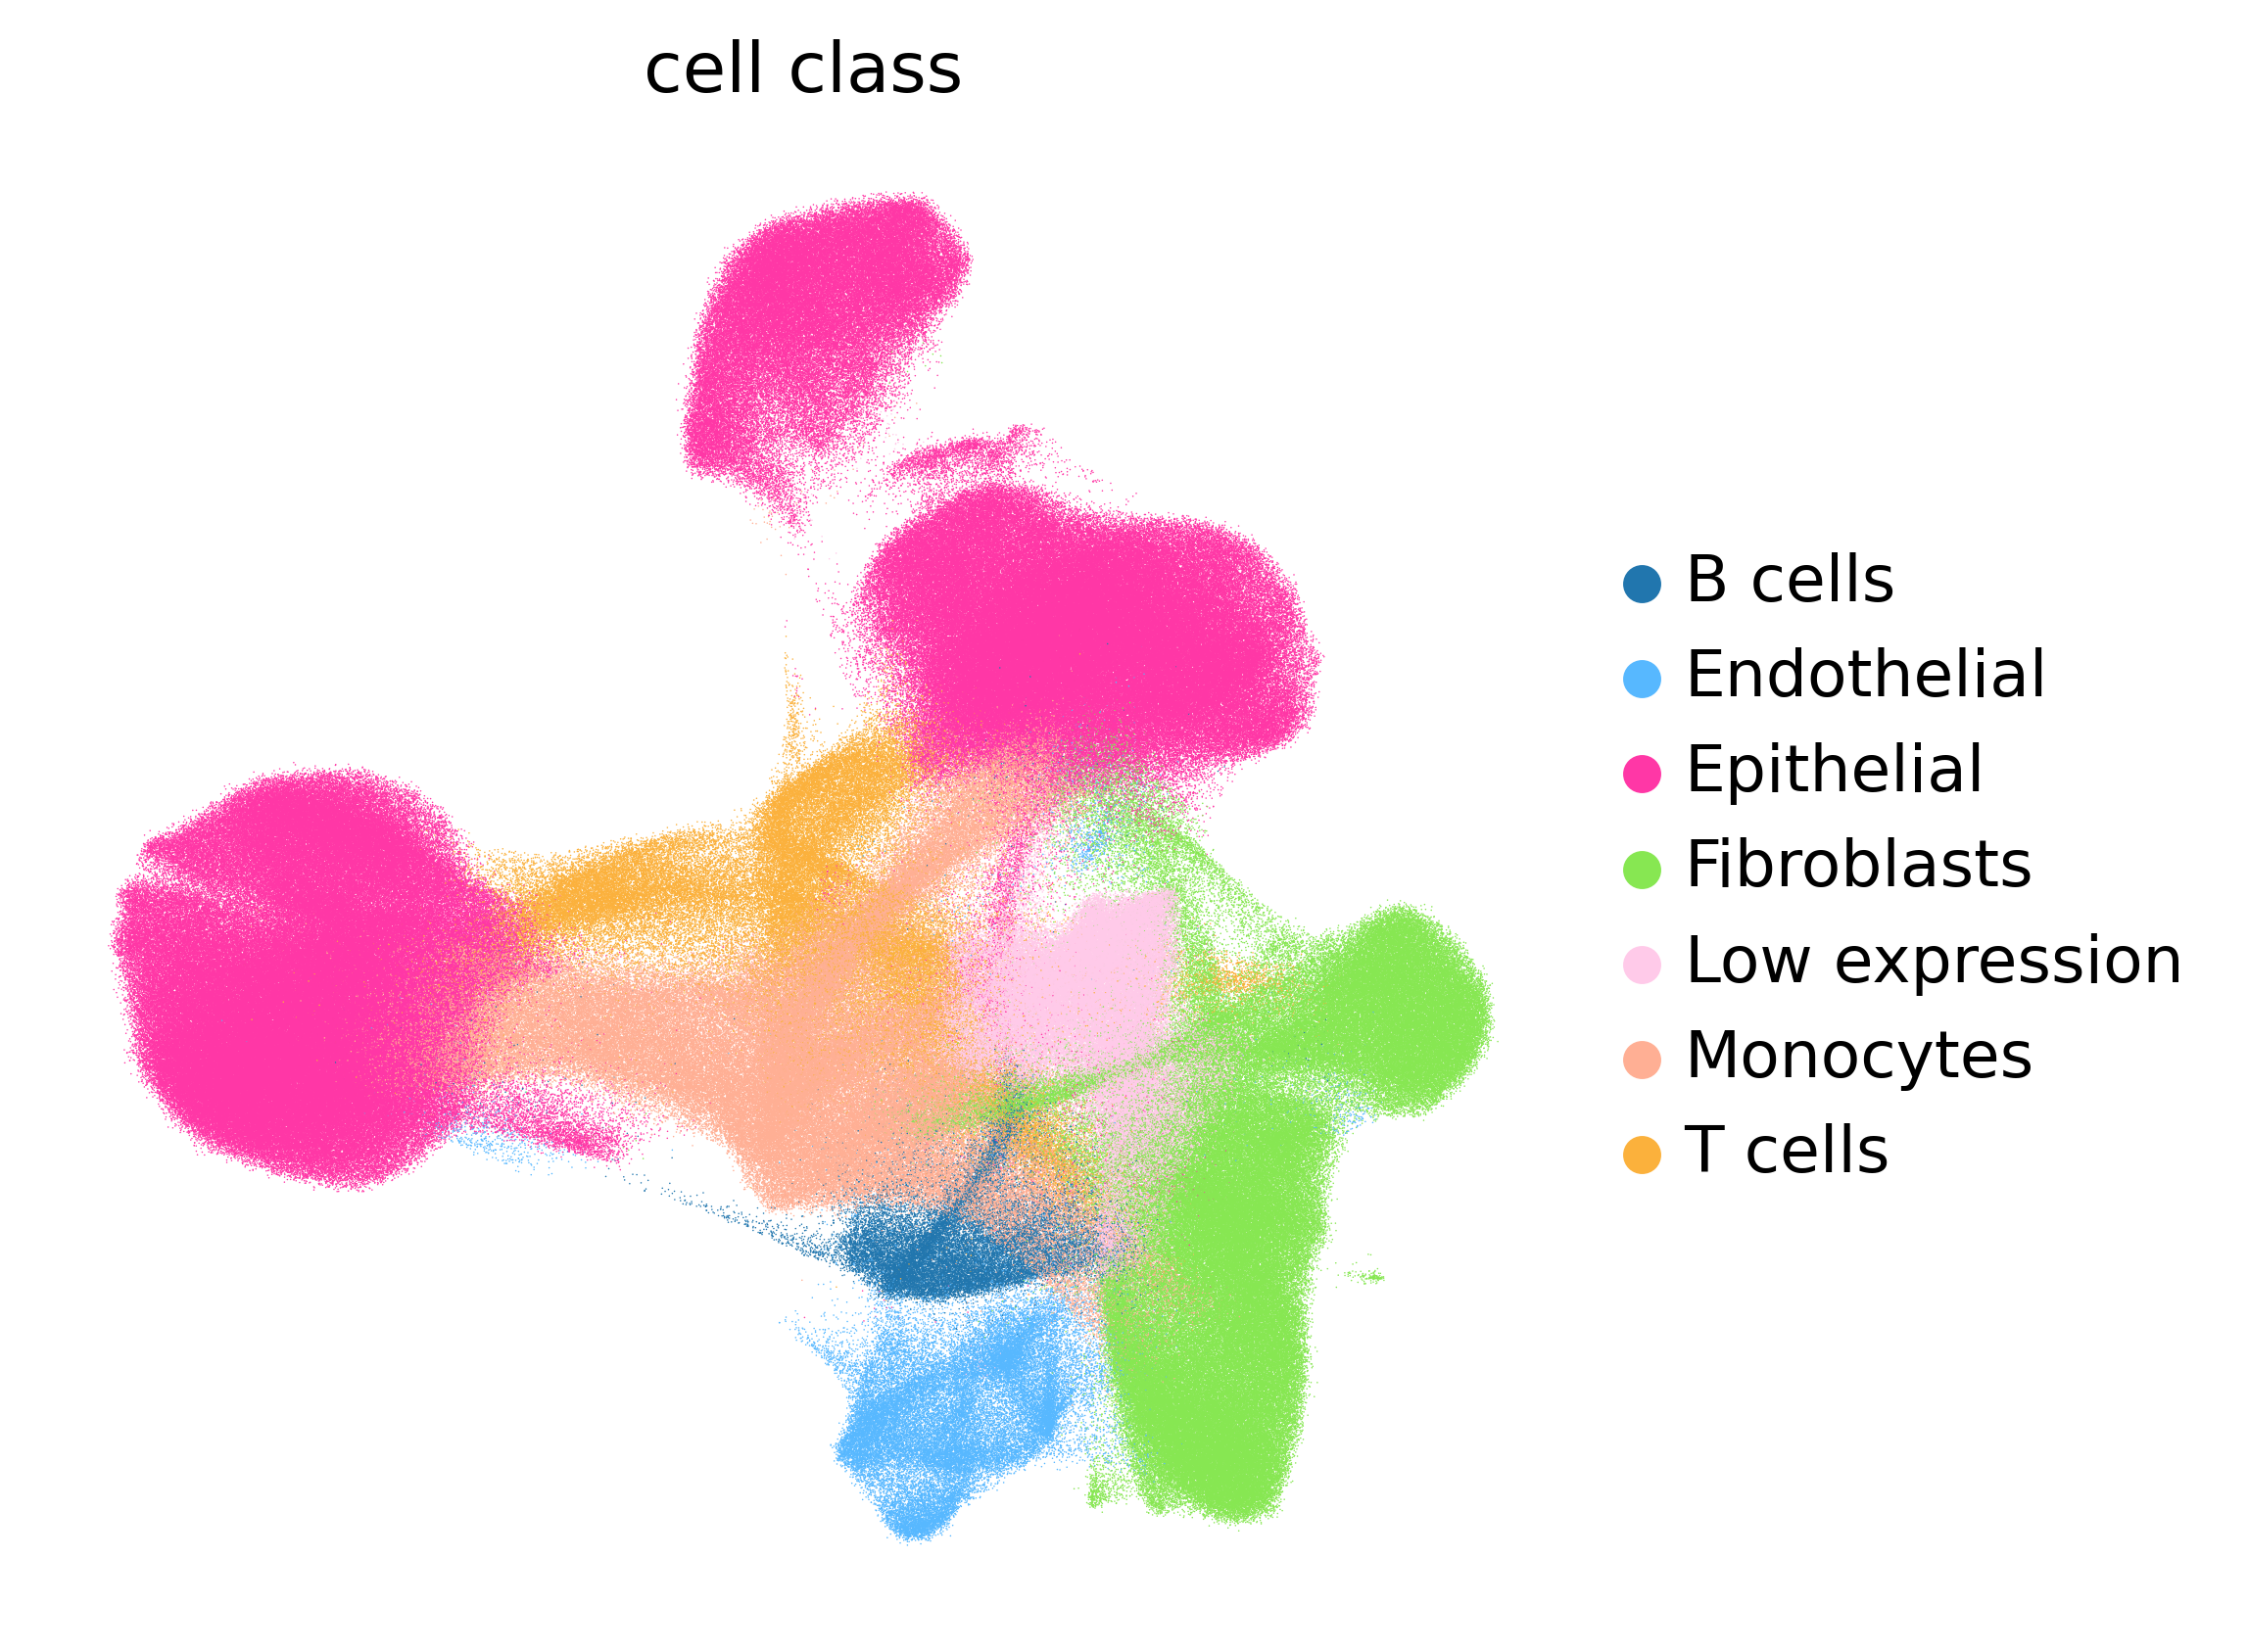

In [93]:
import matplotlib
sc.set_figure_params(scanpy=True, dpi=200, dpi_save=200, frameon=False, vector_friendly=True, fontsize=13, figsize=(5,5), color_map=None, format='pdf', facecolor=None, transparent=False, ipython_format='png2x')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sc.pl.umap(adata,color='cell class',s=0.3,frameon=False,show=False)
plt.savefig(saving_path+'/UMAP_cell_class.pdf')

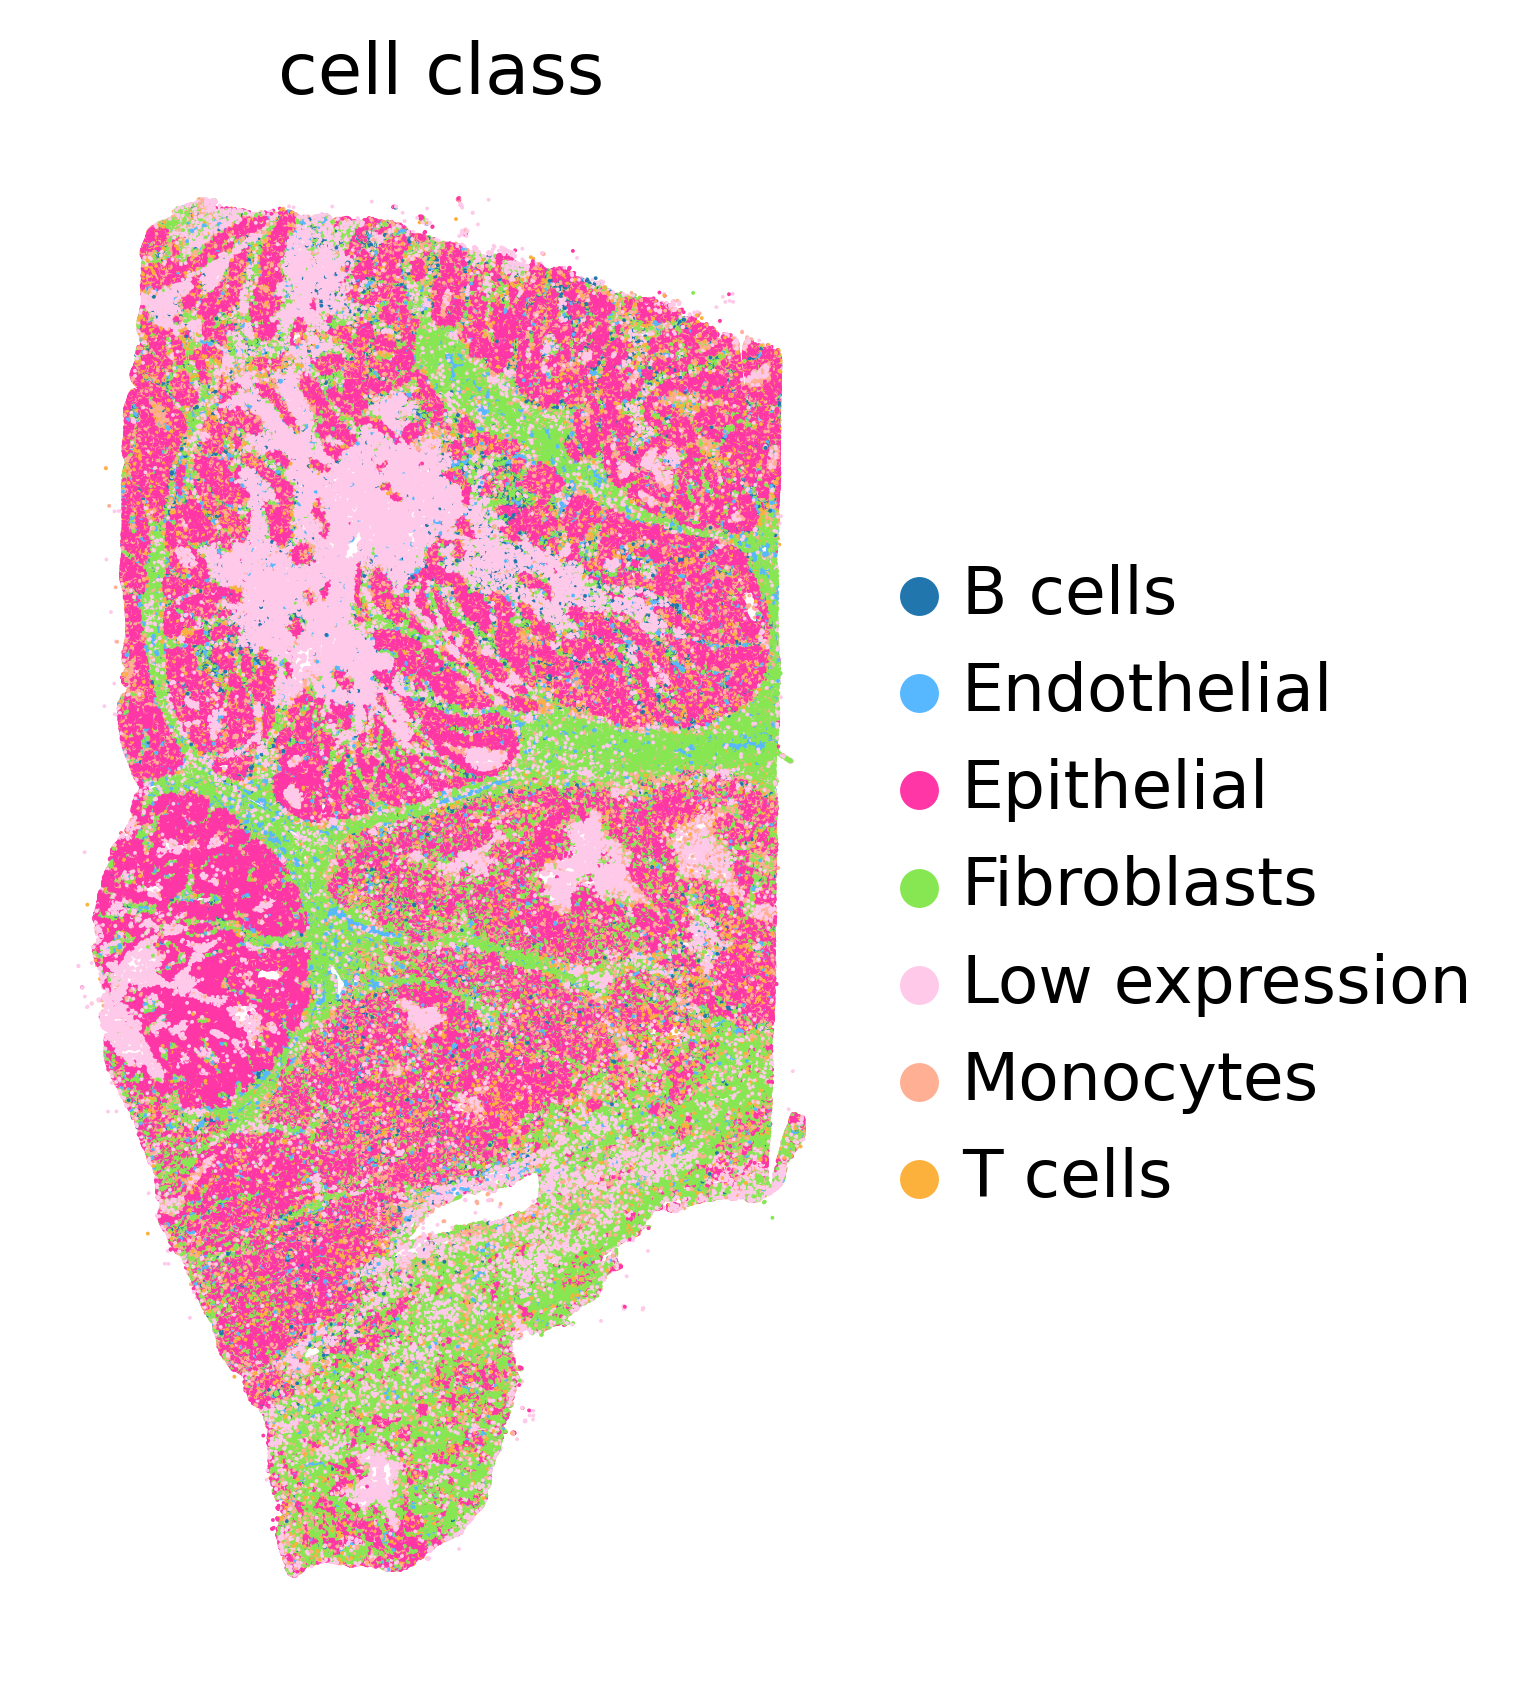

In [94]:
sc.set_figure_params(scanpy=True, dpi=200, dpi_save=200, frameon=False, vector_friendly=True, fontsize=13, figsize=(5,5), color_map=None, format='pdf', facecolor=None, transparent=False, ipython_format='png2x')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sc.pl.spatial(adata,color='cell class',spot_size=60,frameon=False,show=False)
plt.savefig(saving_path+'/spatial_cell_class.pdf')

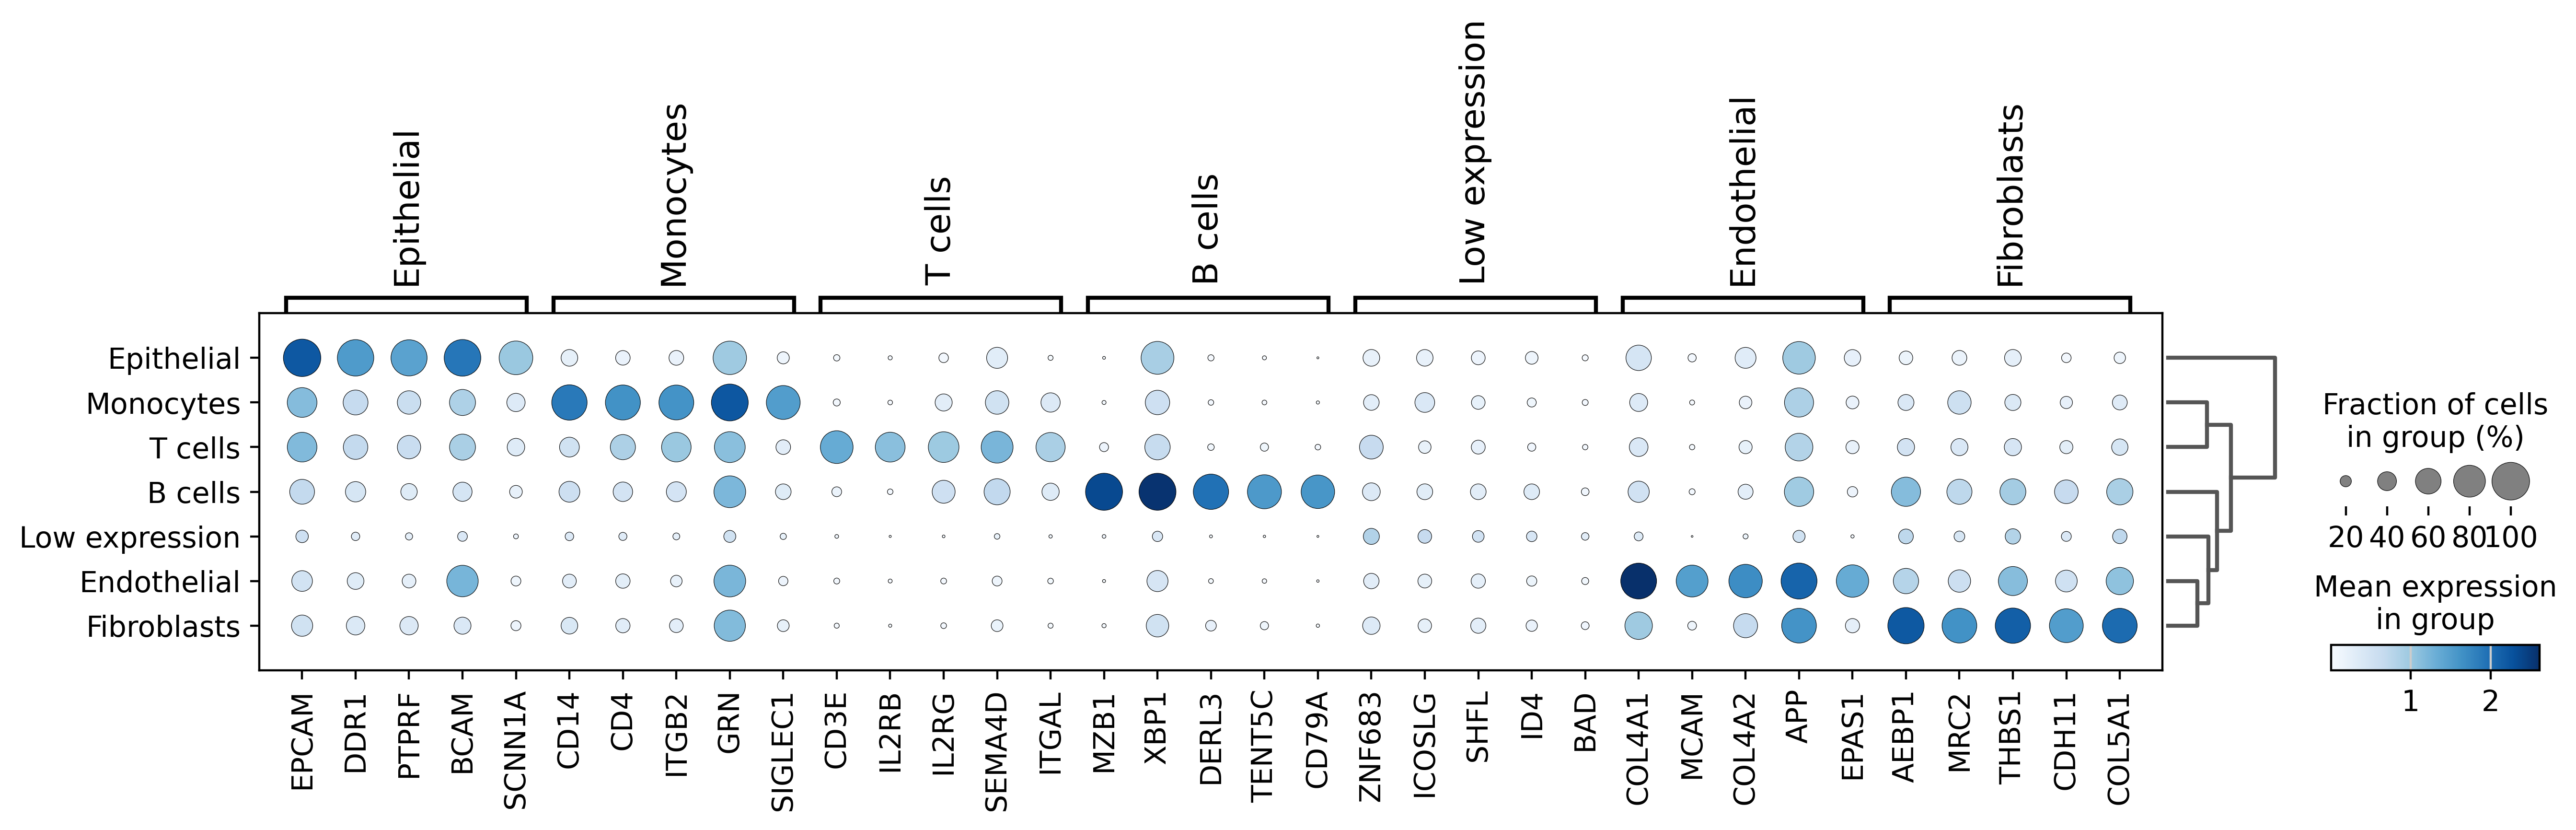

In [97]:
sc.tl.dendrogram(adata,groupby='cell class')
sc.tl.rank_genes_groups(adata,groupby='cell class')
sc.set_figure_params(scanpy=True, dpi=200, dpi_save=200, frameon=False, vector_friendly=True, fontsize=13, figsize=(5,5), color_map=None, format='pdf', facecolor=None, transparent=False, ipython_format='png2x')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sc.pl.rank_genes_groups_dotplot(adata,n_genes=5,cmap='Blues',show=False)
plt.savefig(saving_path+'/dotplot_cell_class.pdf')

#### We add the lognorm counts to a layer and save the object

In [99]:
adata.layers['lognorm']=adata.X.copy()

In [ ]:
adata.write('/media/sergio/Ymir/5kovarian_for_cnv/adata_annotated.h5ad')